# The Future is Now: Patterns in Global Temperature Trends Across the World

Continued from `Analysis 3 Cluster Hierarchical.ipynb`.

## Dependency Installation & Imports

In [1]:
%pip install pandas numpy scikit-learn matplotlib missingno pyarrow pycountry_convert kgcpy scipy fastdtw statsmodels networkx pyvis

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fastdtw import fastdtw
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import euclidean
from scipy.stats import linregress

In [3]:
pd.set_option('display.max_rows', 12)
pd.set_option('display.max_columns', 12)
global_correlation = 0.8770524844965029

## Further Pattern Examination

### Data Preparation (Standardization)

In [4]:
with open('Data_augmented.csv', 'r') as file:
    df = pd.read_csv(file)

df = df.drop(['Latitude', 'Longitude', 'AbsLatitude', 'AbsLongitude'], axis=1)

df.head()

,City,Year,AverageTemperature,Country,NumericLatitude,NumericLongitude,Continent,kcc
0,Abidjan,1880,25.957083,Cote D'Ivoire,5.63,-3.23,Africa,Aw
1,Abidjan,1881,26.073333,Cote D'Ivoire,5.63,-3.23,Africa,Aw
2,Abidjan,1882,25.687167,Cote D'Ivoire,5.63,-3.23,Africa,Aw
3,Abidjan,1883,26.131333,Cote D'Ivoire,5.63,-3.23,Africa,Aw
4,Abidjan,1884,26.366625,Cote D'Ivoire,5.63,-3.23,Africa,Aw


In [5]:
# Create a temperature profile for each city
city_profiles = df.pivot(index='Year', columns='City', values='AverageTemperature').ffill().bfill()

# Normalize with z-scores
city_profiles_standardized = (city_profiles - city_profiles.mean()) / city_profiles.std()

for city in city_profiles_standardized:
    assert city_profiles_standardized[city].values.ndim == 1, f"{city} profile is not 1-D"

# Euclidean distances between all city pairs
distances_euclid = pdist(city_profiles_standardized.transpose(), metric='euclidean')

# condensed distance matrix -> square
matrix_euclid = squareform(distances_euclid)

# DTW distance matrix
cities = city_profiles_standardized.columns
num_cities = len(cities)
matrix_dtw = np.zeros((num_cities, num_cities))

# Inputs need to be 1 dimensional
def euclidean_distance_wrapper(x, y):
    x_flat = np.array(x).flatten()
    y_flat = np.array(y).flatten()
    return euclidean(x_flat, y_flat)

for i in range(num_cities):
    # Only need upper triangle since it will be symmetrical about the diagonal
    for j in range(i + 1, num_cities):
        city1, city2 = cities[i], cities[j]
        distance, _ = fastdtw(city_profiles_standardized[city1].values, city_profiles_standardized[city2].values, dist=euclidean_distance_wrapper)
        # Make it symmetrical
        matrix_dtw[i, j] = distance
        matrix_dtw[j, i] = distance
        
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
matrix_cities = mds.fit_transform(matrix_dtw)

### Density-Based Clustering

Using DBSCAN

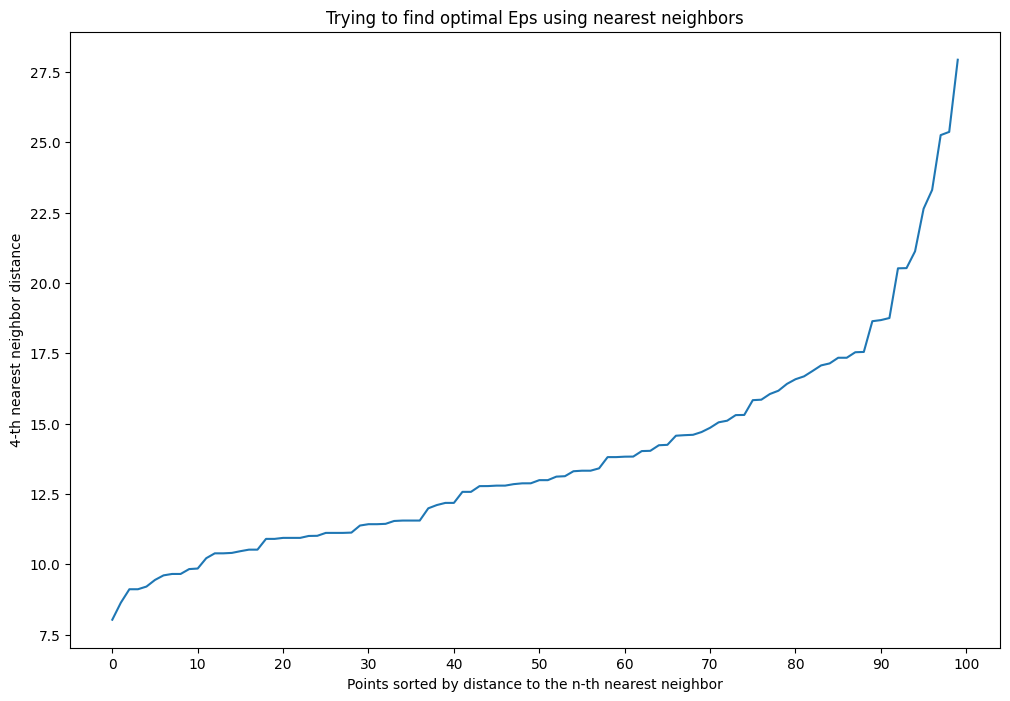

In [6]:
X = matrix_cities

n_neighbors = 5 # arbitrary, took some fiddling
nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors)
nearest_neighbors.fit(X)
distances, indices = nearest_neighbors.kneighbors(X)

sorted_distances = np.sort(distances[:, n_neighbors-1], axis=0)

plt.figure(figsize=(12,8))
plt.plot(sorted_distances)
plt.xticks(range(0, 110, 10))
plt.xlabel("Points sorted by distance to the n-th nearest neighbor")
plt.ylabel(f"{n_neighbors-1}-th nearest neighbor distance")
plt.title("Trying to find optimal Eps using nearest neighbors")
plt.show()

The "elbow" seems to be around x=88 but it results in an estimation of just 1 cluster... let's see how results change as we adjust the elbow index.

constants: min_samples_value is 5

Elbow index|10|15|20|25|30|35|40|45|50|55|60|65|70|75|80|85
-----------|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--
Eps value|9.85|10.47|10.94|11.12|11.43|11.55|12.18|12.8|12.99|13.33|13.82|14.25|14.85|15.83|16.58|17.34
Estimated number of clusters|6|6|5|5|6|6|7|5|4|3|2|2|2|2|2|1
Estimated number of noise points|69|64|58|52|41|40|28|25|22|20|18|16|13|4|2|2

Based on this information (retrieved by making modifications to the `elbow_index` value in cell below), it looks like an eps from 12.18 to 12.8 is a good sweet spot, i.e. an elbow index of 40 to 45. I will be using 43 for DBSCAN.

In [42]:
elbow_index = 43
eps_value = sorted_distances[elbow_index] # determined from the plot
print(f'eps value is: {eps_value}')
min_samples_value = 5

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value).fit(X)
labels = dbscan.labels_

# num clusters in labels, ignore noise if present
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

eps value is: 12.77836559928429
Estimated number of clusters: 7
Estimated number of noise points: 26


1. Choose Parameters eps and min_samples:
   * eps: The maximum distance between two samples for them to be considered in the same neighborhood.
   * min_samples: The number of samples in a neighborhood for a point to be considered a core point.

DBSCAN labels each point with a cluster label or -1 for noise/outliers.

Comparing to k-means and Hierarchical:
* Cluster Quality: Evaluate using silhouette scores, noting that DBSCAN may produce a "noise" category (-1 label) for outliers.
* Robustness to Outliers: DBSCAN's ability to identify and exclude outliers may lead to more robust clustering than k-means or hierarchical clustering, especially if outliers distorted the k-means results.
* Cluster Interpretation: Similarly, analyze the resulting clusters in terms of continents, KCC's relative abundance, and regression correlations, as with hierarchical clustering.

In [43]:
city_cluster_df = pd.DataFrame({'City': cities, 'Cluster': labels})

df_merged = pd.merge(df, city_cluster_df, on='City', how='left')

#### Cluster Visualizations

~~1. Unique Cities in each cluster~~
~~2. Unique Countries in each cluster~~
3. Proportion of Continents in each cluster relative to all data
   1. Bar graph with absolute abundance
   2. Heat map with relative abundance
4. Proportion of climates in each cluster relative to all data
   1. Bar graph with absolute abundance
   2. Heat map with relative abundance
5. For each cluster:
   ~~1. Averaged AverageTemperature by Year & correlations~~
   2. AverageTemperature by Year & correlations
   3. Box & Whiskers plots to look at geographic spread (Latitude, Longitude)

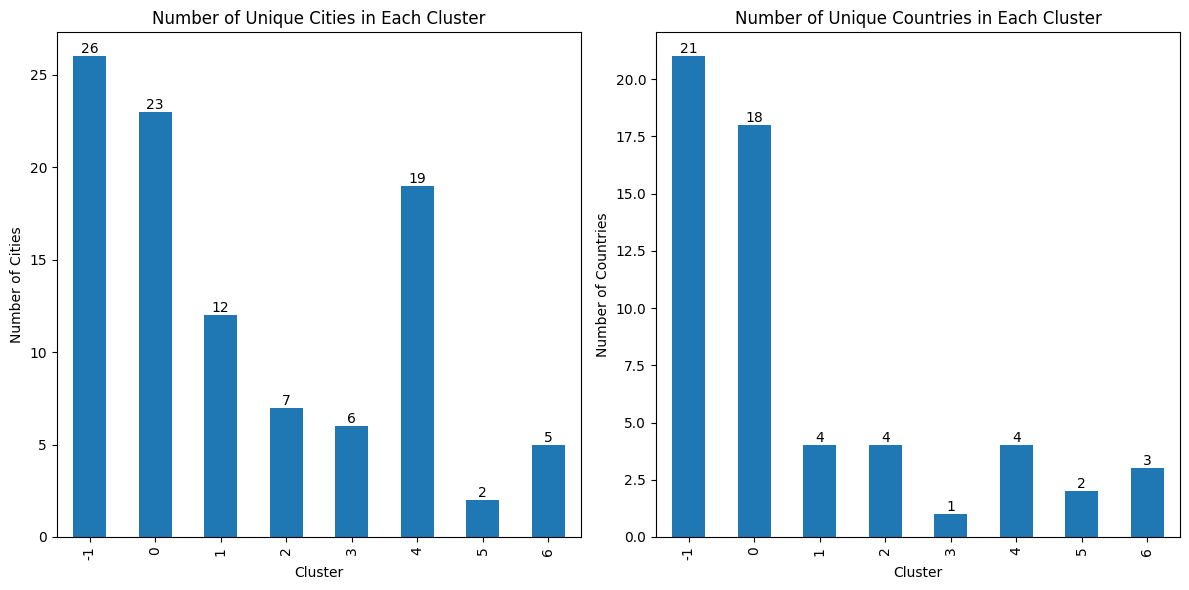

Cluster of -1 indicates noise points


In [44]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
cities_per_cluster = df_merged.groupby('Cluster')['City'].nunique()
cities_per_cluster.plot(kind='bar')
plt.title('Number of Unique Cities in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Cities')
for index, value in enumerate(cities_per_cluster):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.subplot(1, 2, 2)
countries_per_cluster = df_merged.groupby('Cluster')['Country'].nunique()
countries_per_cluster.plot(kind='bar')
plt.title('Number of Unique Countries in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Countries')
for index, value in enumerate(countries_per_cluster):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print('Cluster of -1 indicates noise points')

Visualization & correlation of averaged clusters

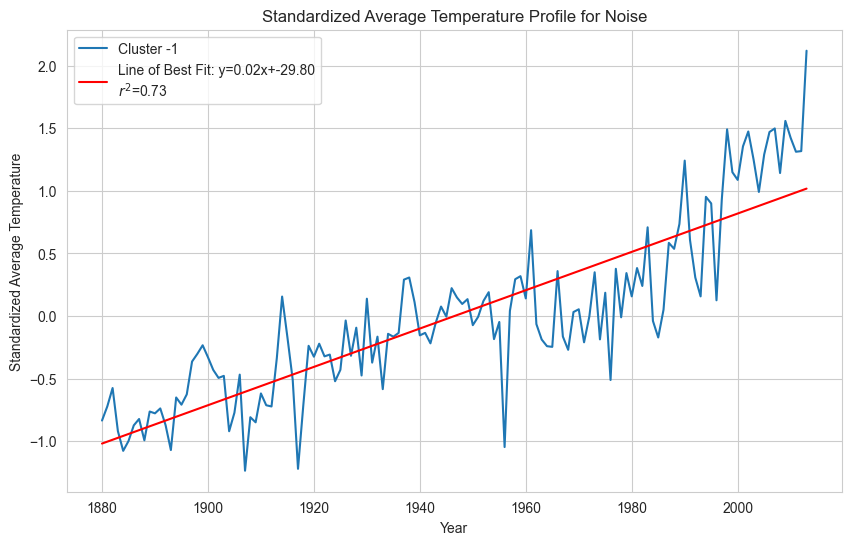

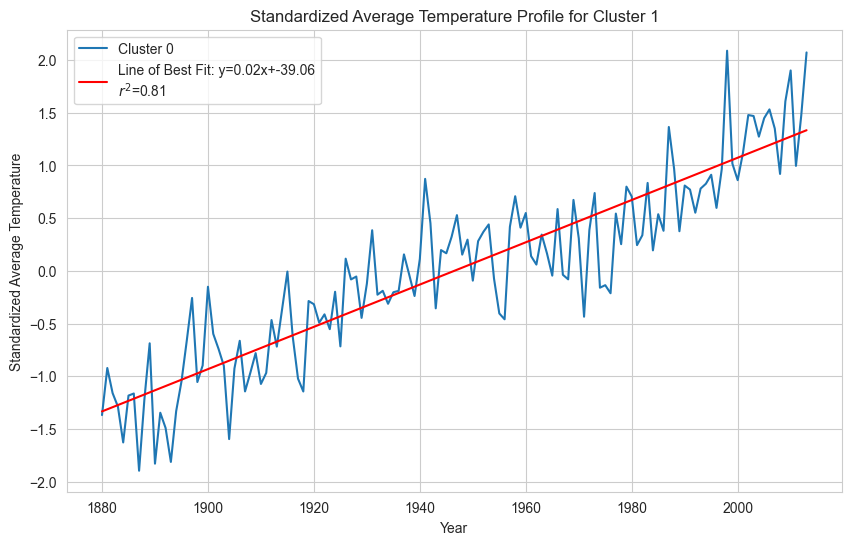

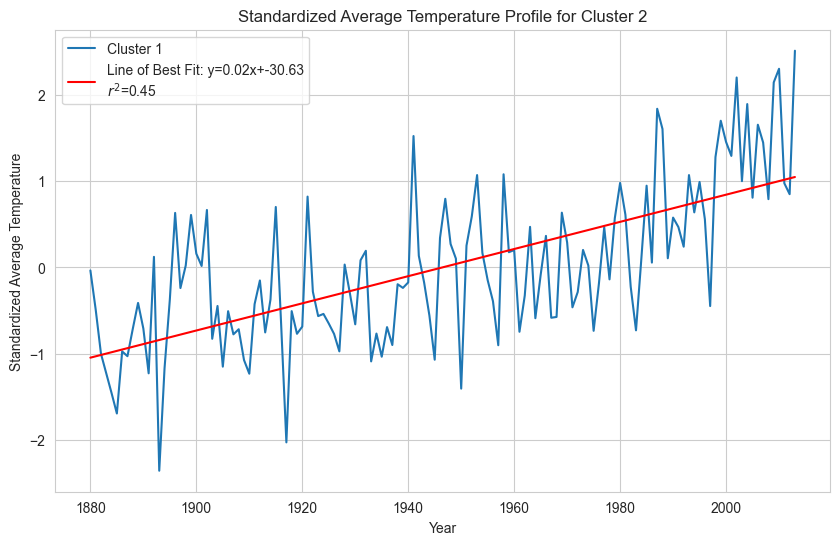

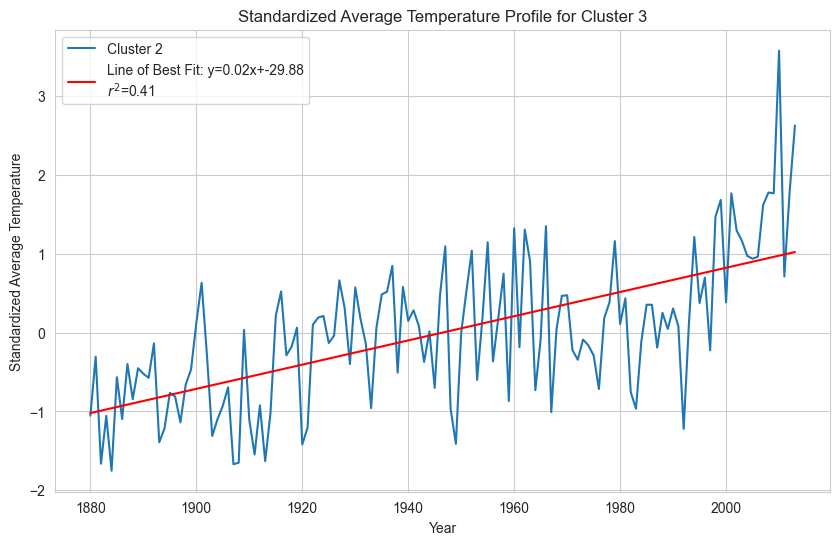

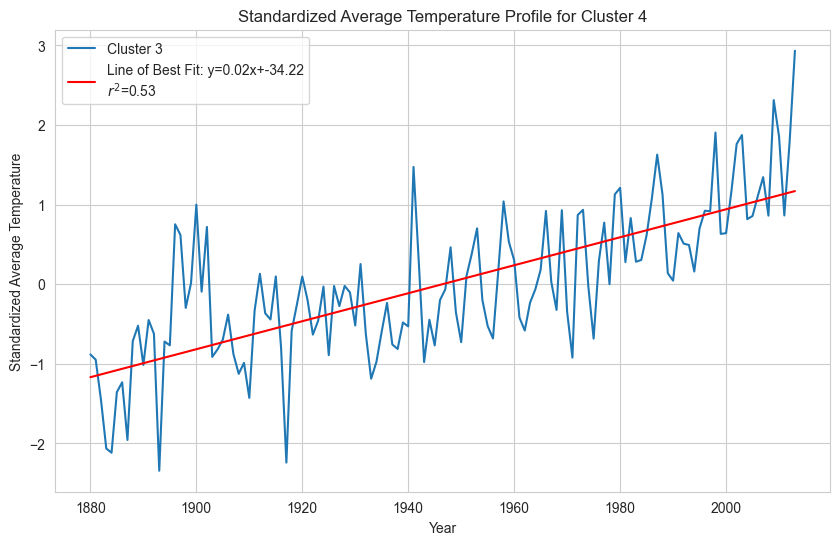

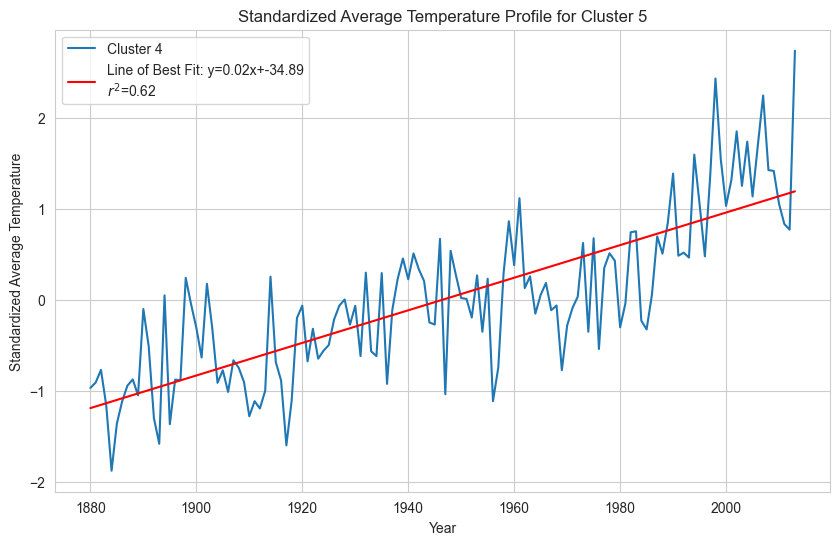

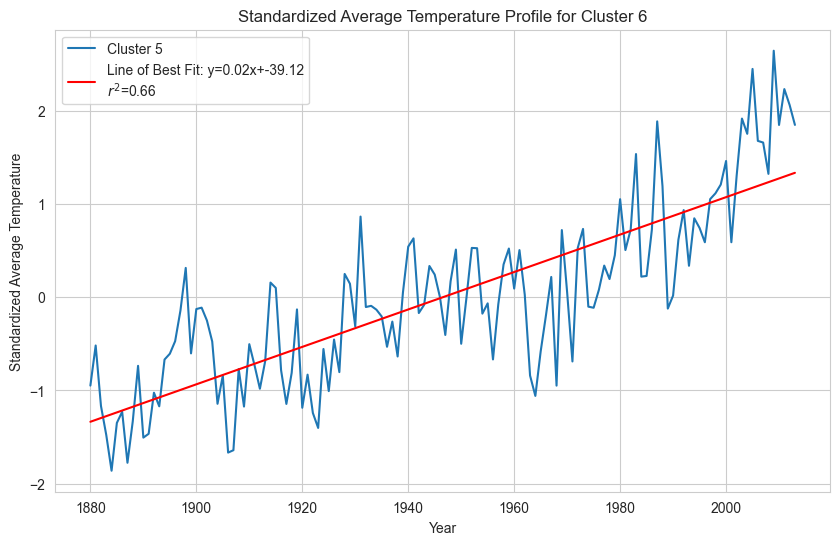

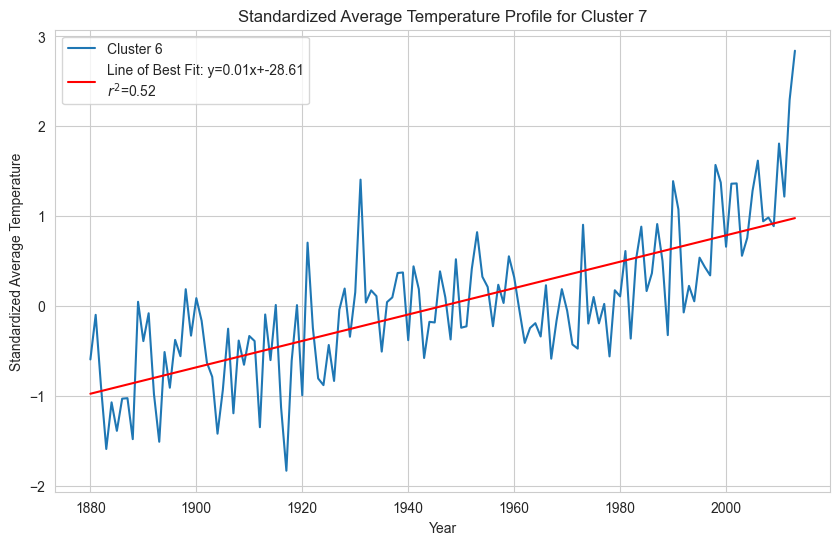

In [49]:
city_profiles_standardized.reset_index(inplace=True)

n_clusters = np.sort(df_merged['Cluster'].unique())

for cluster in n_clusters:
    # Extract cities belonging to the current cluster
    cluster_cities = df_merged[df_merged['Cluster'] == cluster]['City'].unique()
    cluster_profiles = city_profiles_standardized[cluster_cities]

    mean_profile = cluster_profiles.mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(city_profiles_standardized['Year'], mean_profile, label=f'Cluster {cluster}')

    # Line of best fit
    slope, intercept, r_value, _, _ = linregress(city_profiles_standardized['Year'].astype(float), mean_profile)
    line = slope * city_profiles_standardized['Year'].astype(float) + intercept
    plt.plot(city_profiles_standardized['Year'], line, 'r', label=f'Line of Best Fit: y={slope:.2f}x+{intercept:.2f}\n$r^2$={r_value**2:.2f}')

    cluster_label = 'Noise' if cluster == -1 else f'Cluster {cluster+1}'
    plt.title(f'Standardized Average Temperature Profile for {cluster_label}')
    plt.xlabel('Year')
    plt.ylabel('Standardized Average Temperature')
    plt.legend()
    plt.show()

Non-averaged clusters

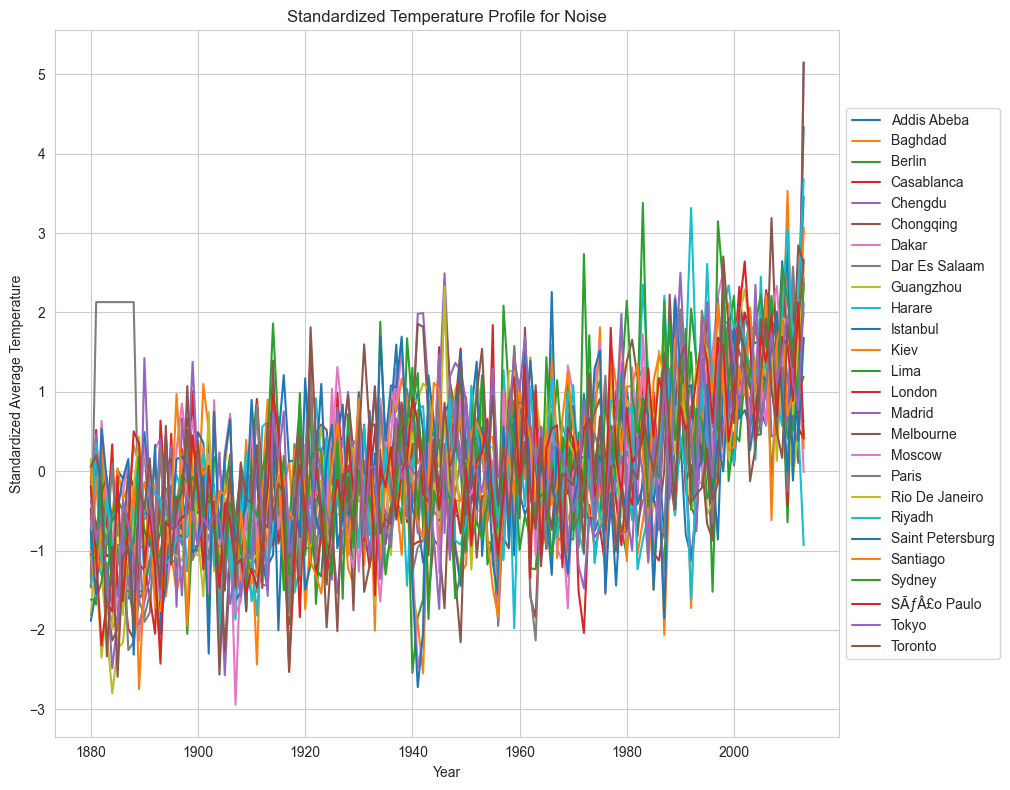

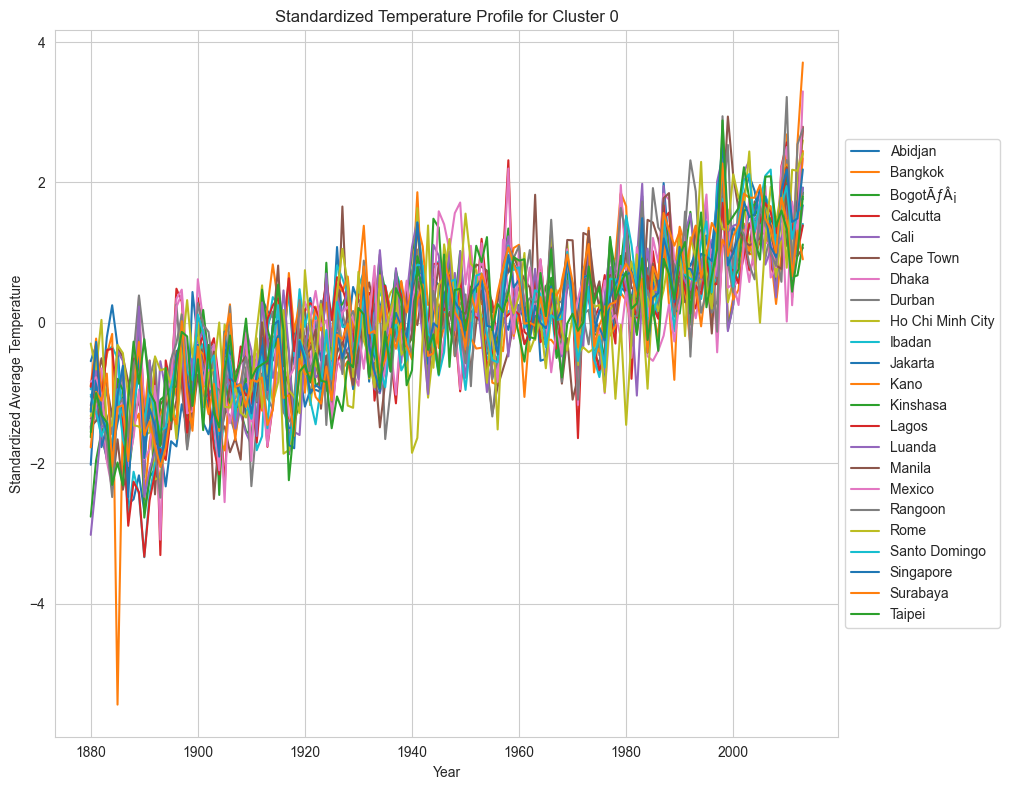

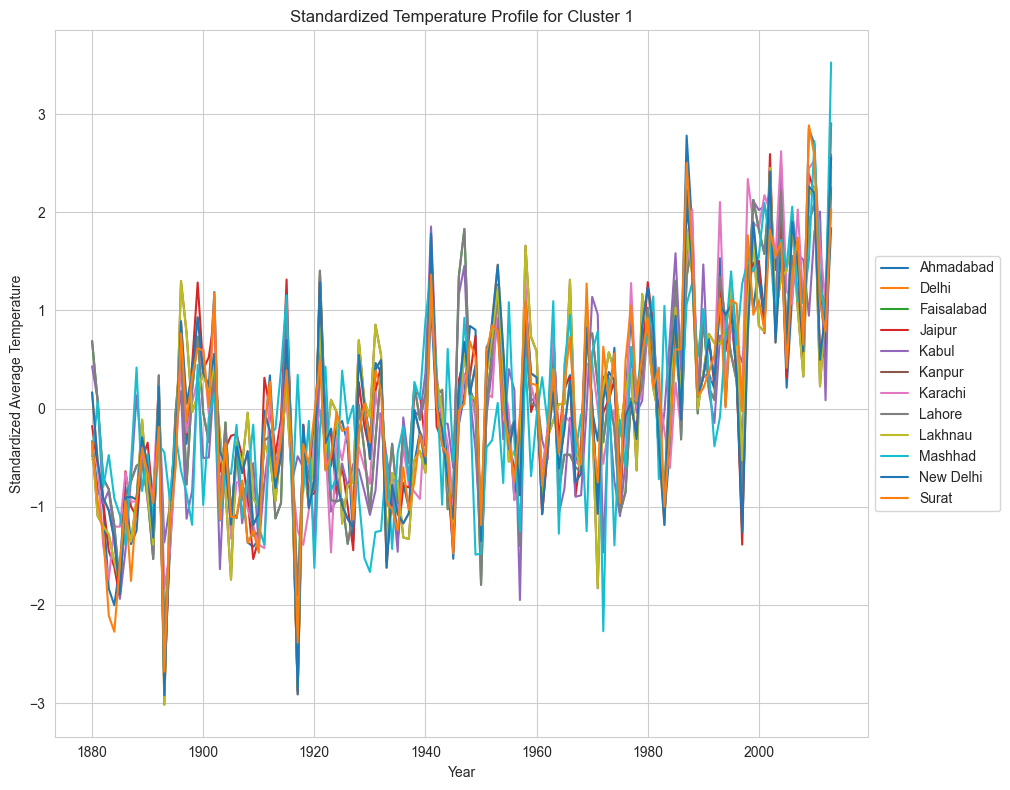

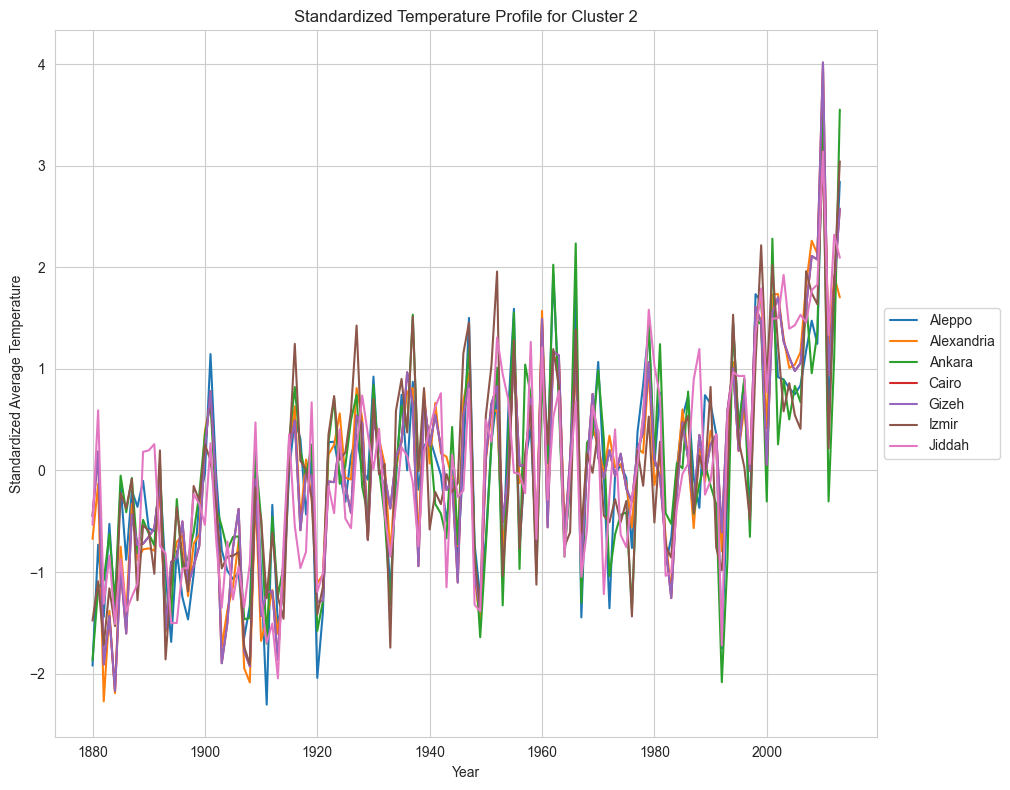

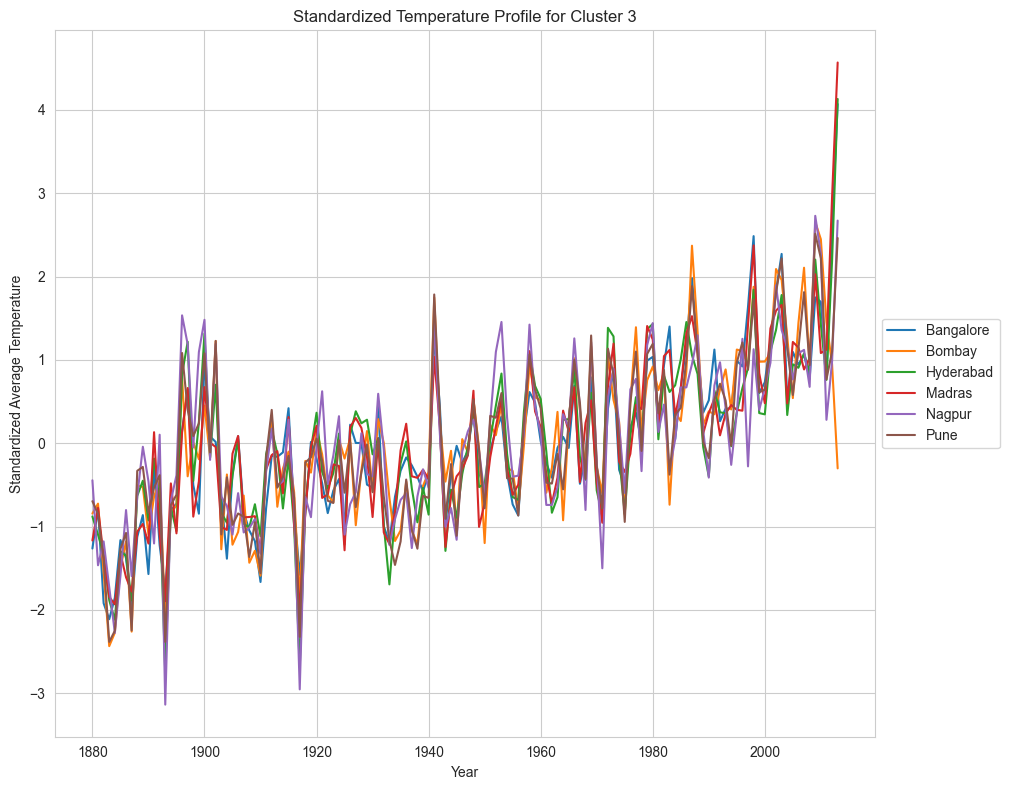

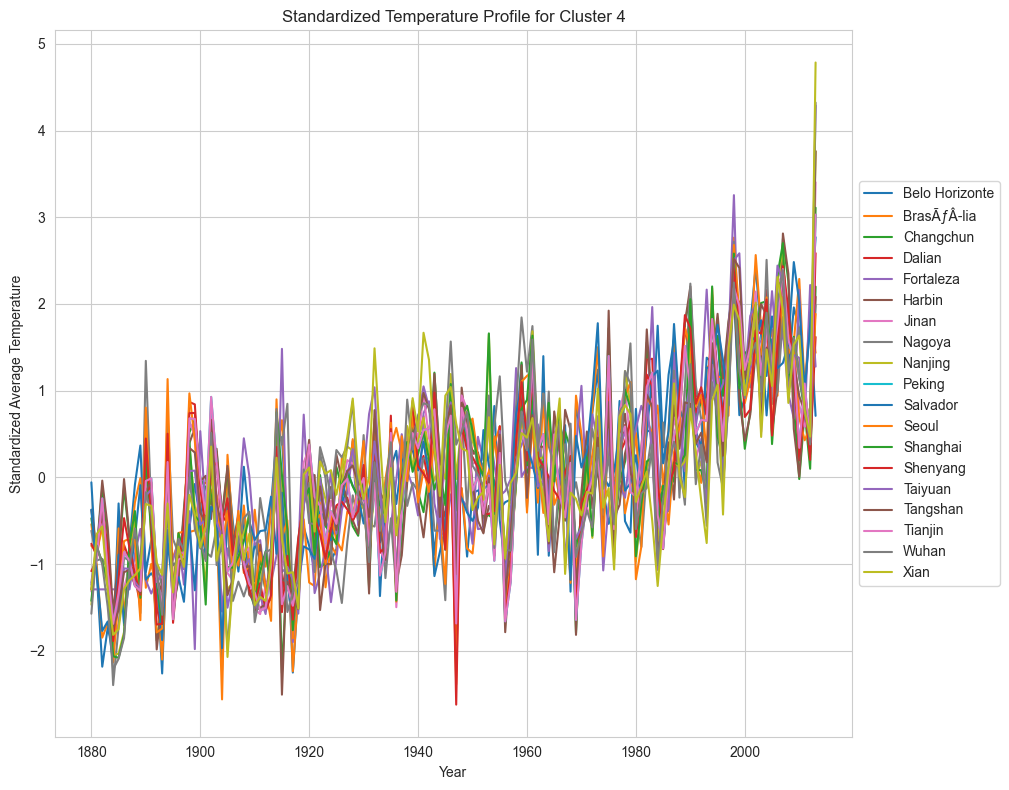

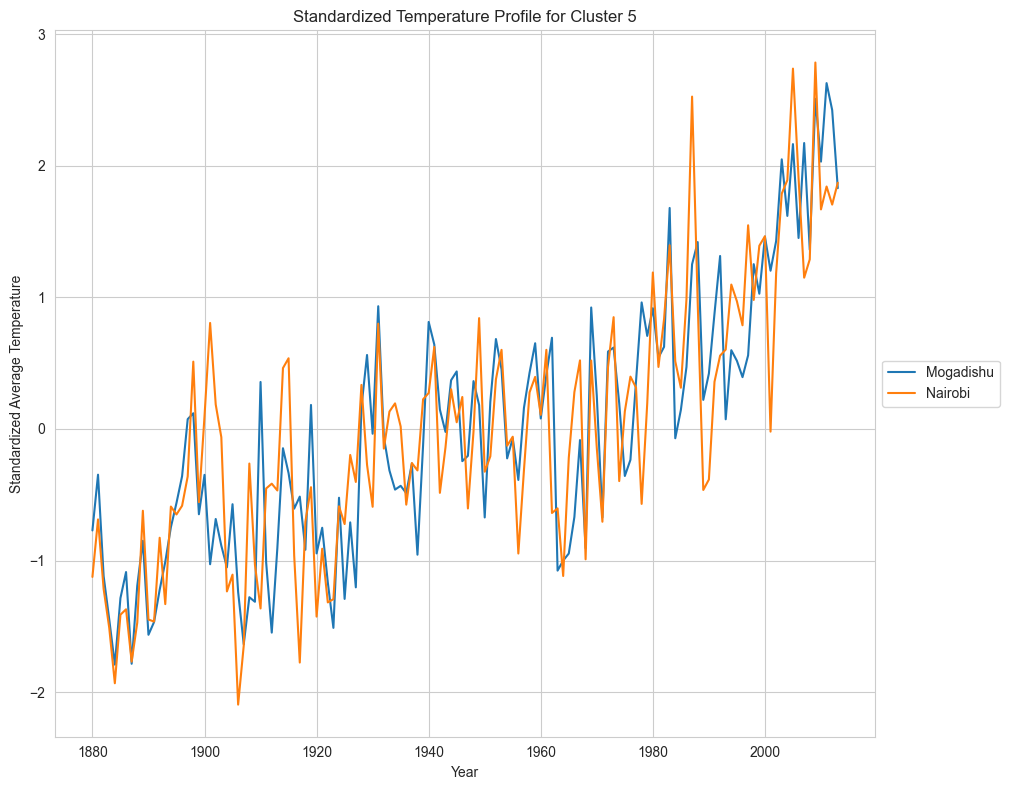

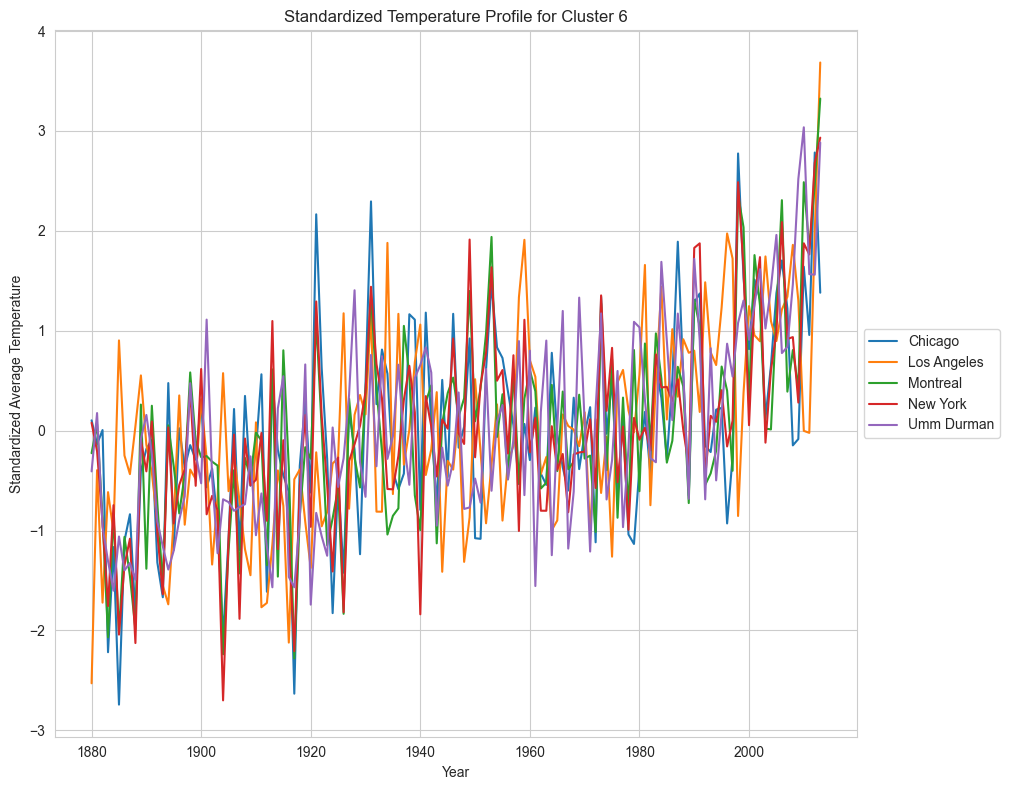

In [50]:
for cluster in n_clusters:
    plt.figure(figsize=(12, 8))
    cluster_cities = df_merged[df_merged['Cluster'] == cluster]['City'].unique()

    for city in cluster_cities:
        city_profile = city_profiles_standardized[[city, 'Year']].dropna()
        plt.plot(city_profile['Year'], city_profile[city], label=city)

    cluster_label = 'Noise' if cluster == -1 else f'Cluster {cluster}'
    plt.title(f'Standardized Temperature Profile for {cluster_label}')
    plt.xlabel('Year')
    plt.ylabel('Standardized Average Temperature')

    # Place the legend outside the plot to the right
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect to prevent cutting off the legend
    plt.show()

Relative abundance of continents

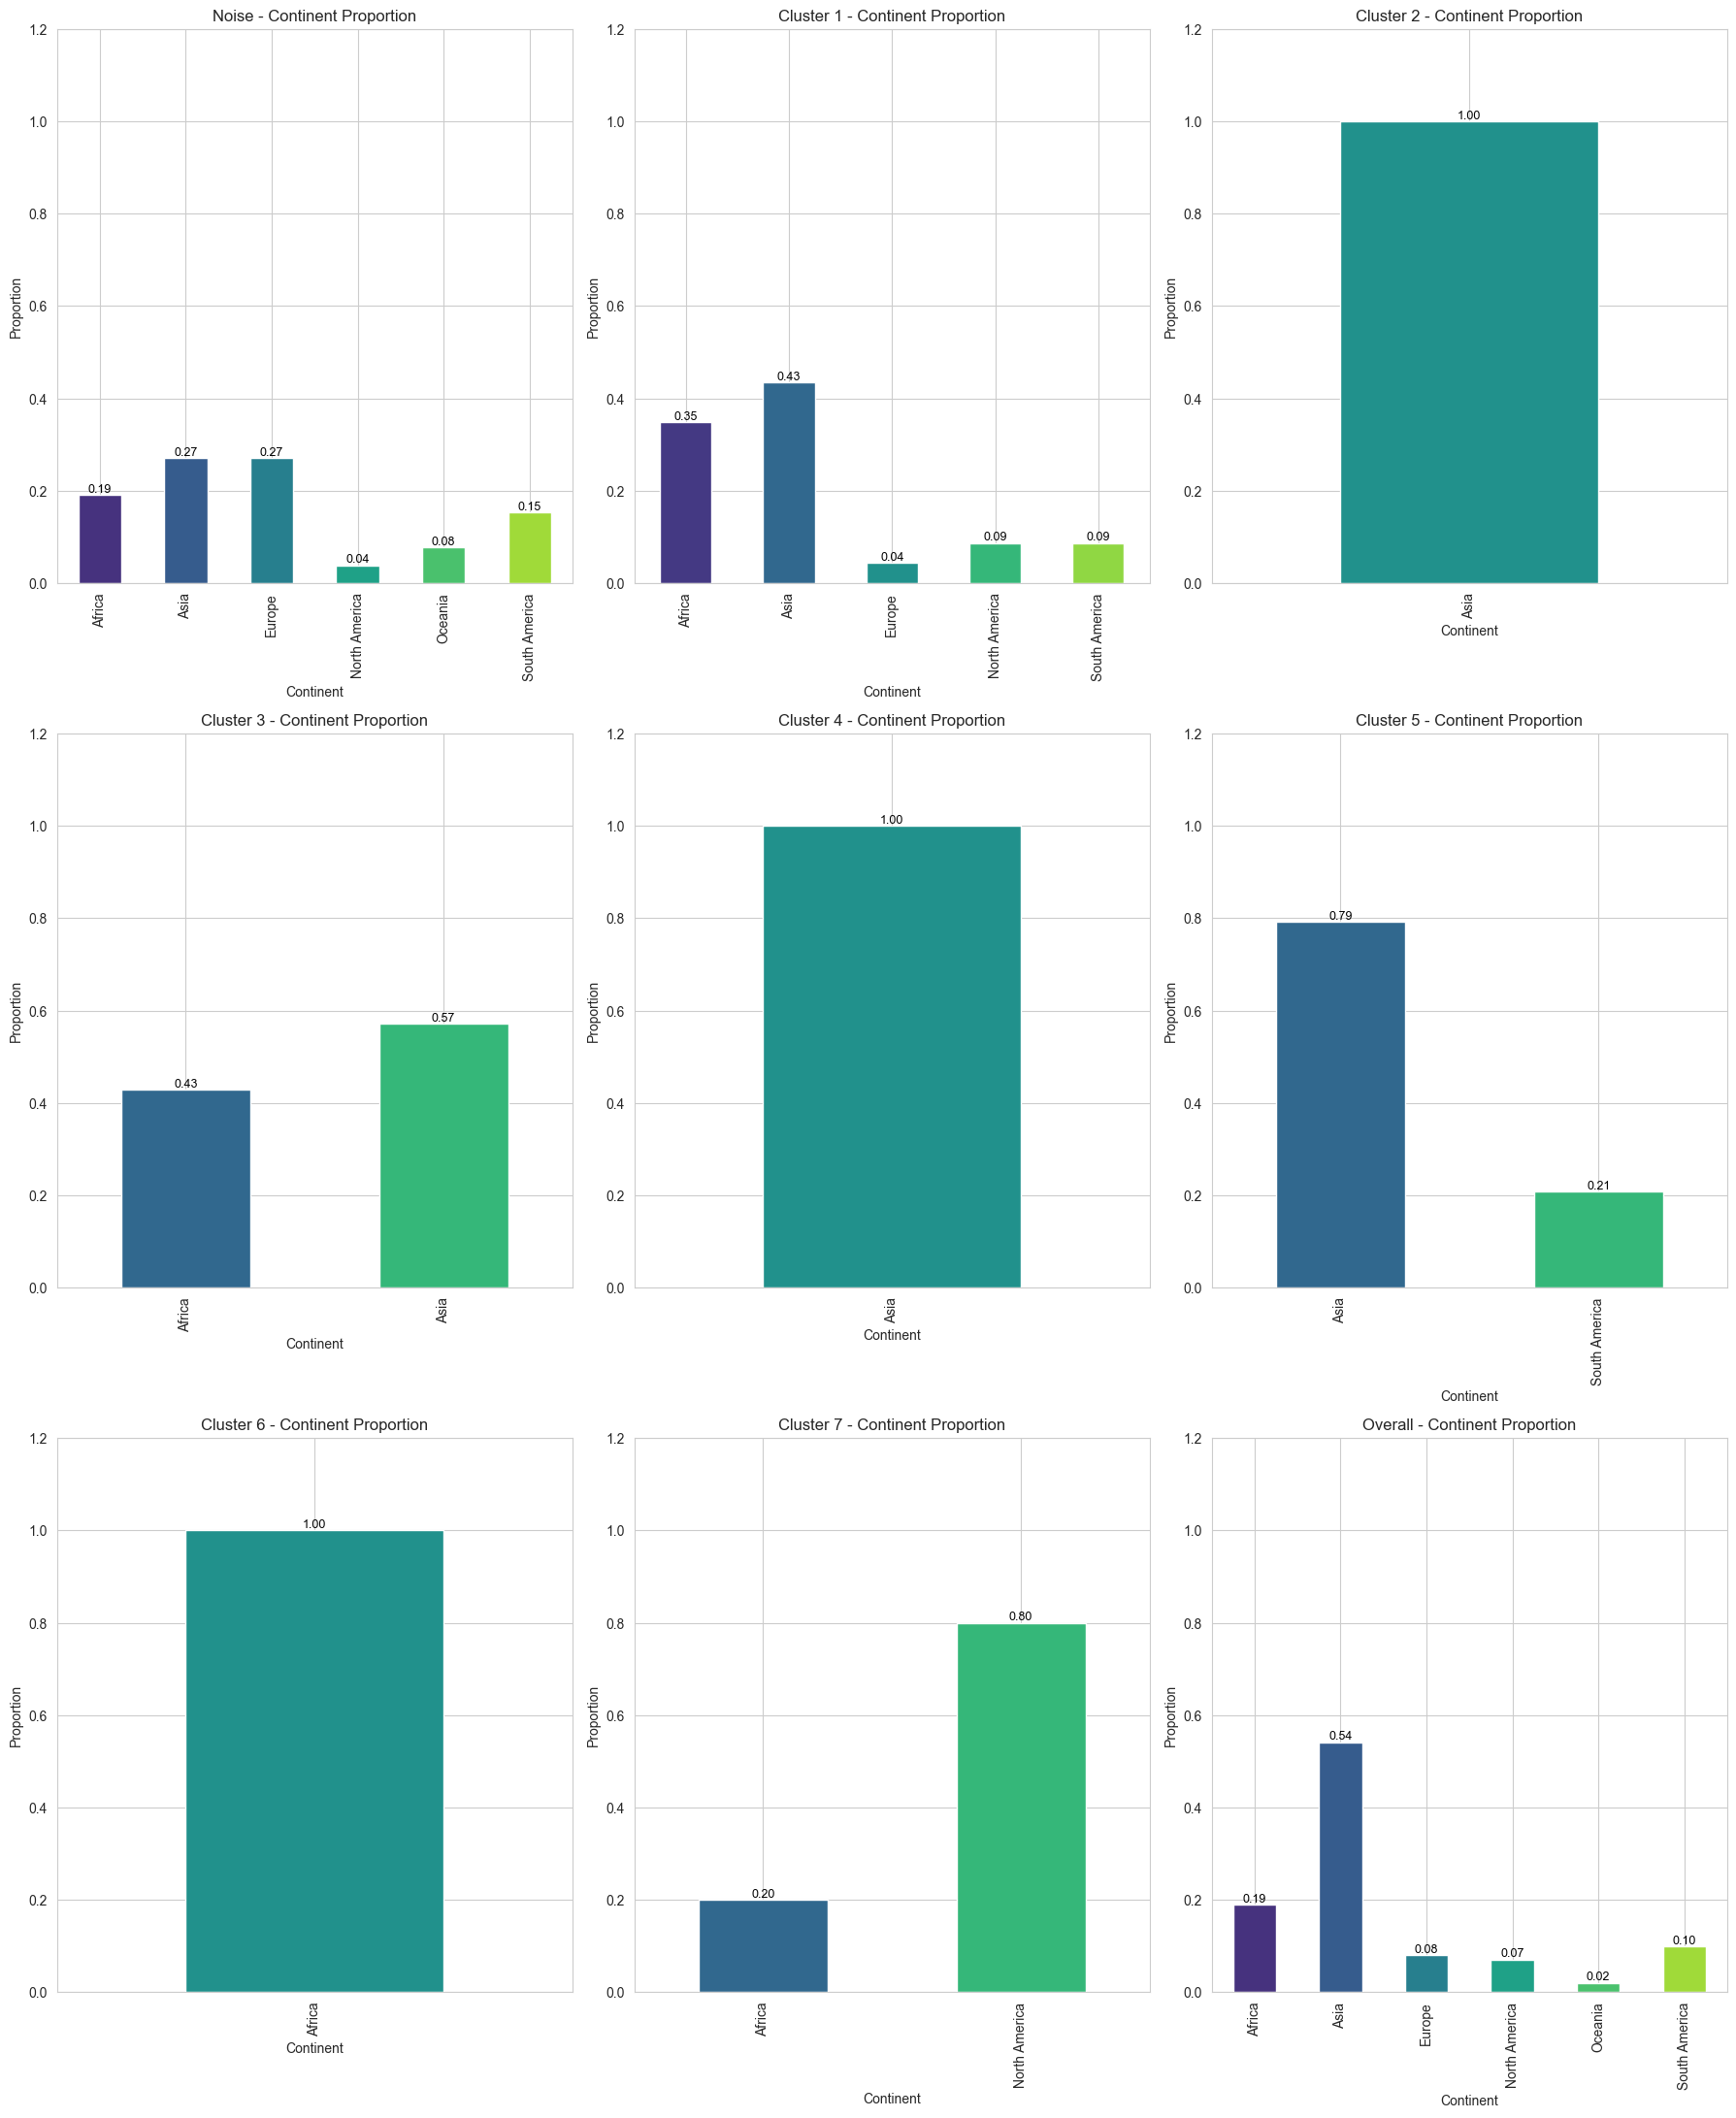

In [56]:
def add_labels(ax, values):
    for index, value in enumerate(values):
        ax.text(index, value, f"{value:.2f}", ha='center', va='bottom', fontsize=9, color='black')

n_clusters = len(np.sort(df_merged['Cluster'].unique()))

# Calculate grid size for subplots
n_rows = int(np.ceil(n_clusters / 3)) + 1  # Additional row for the overall data
fig, axs = plt.subplots(n_rows, 3, figsize=(18, n_rows * 7))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

# Cluster continent abundance
for i, cluster in enumerate(np.sort(df_merged['Cluster'].unique())):
    ax = axs.flat[i]
    cluster_continent_abundance = df_merged[df_merged['Cluster'] == cluster]['Continent'].value_counts(normalize=True).sort_index()
    
    cluster_continent_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(cluster_continent_abundance)))
    cluster_label = 'Noise' if cluster == -1 else f'Cluster {cluster+1}'
    ax.set_title(f'{cluster_label} - Continent Proportion')
    ax.set_ylabel('Proportion')
    ax.set_ylim(0, 1.2)
    add_labels(ax, cluster_continent_abundance.values)

# overall continent abundance
ax = axs.flat[n_clusters]
overall_continent_abundance = df['Continent'].value_counts(normalize=True).sort_index()
overall_continent_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(overall_continent_abundance)))
ax.set_title('Overall - Continent Proportion')
ax.set_ylabel('Proportion')
ax.set_ylim(0, 1.2)
add_labels(ax, overall_continent_abundance.values)

# Hide any unused subplots
for i in range(n_clusters + 1, n_rows * 3):
    if i < len(axs.flat):
        fig.delaxes(axs.flat[i])

plt.tight_layout()
plt.show()

Relative abundance of Koppen climate classifications

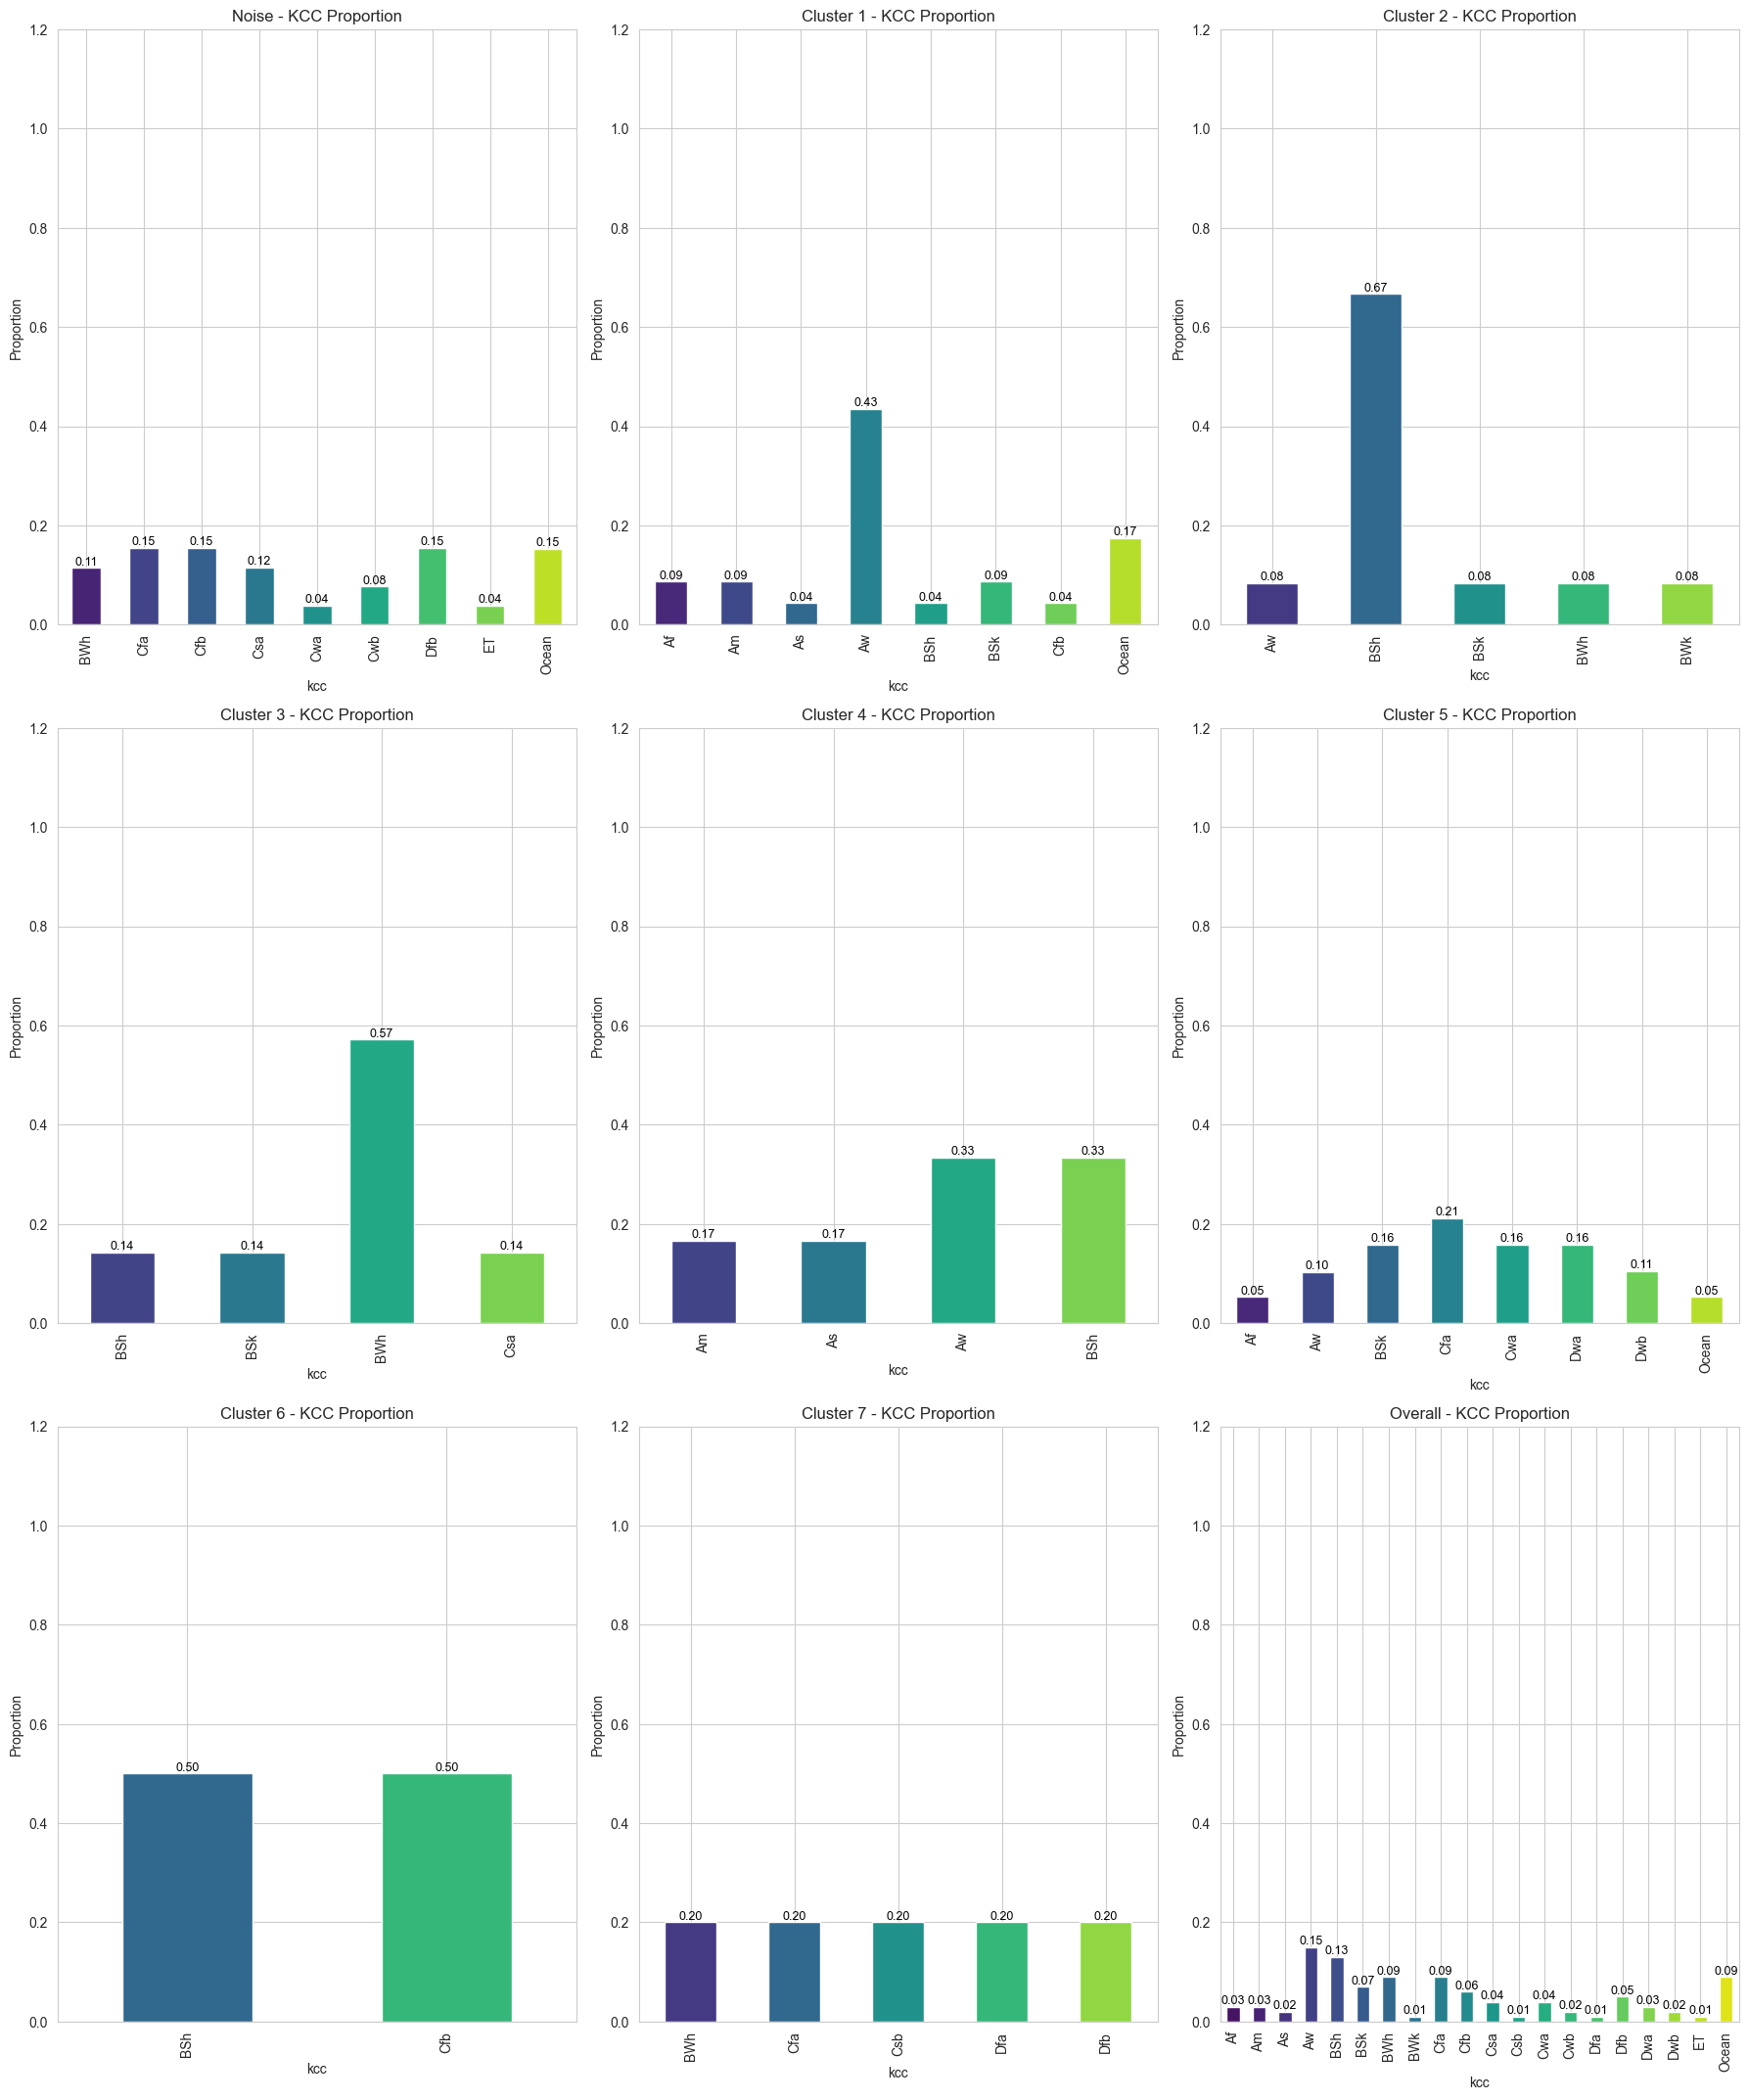

In [57]:
n_rows = int(np.ceil(n_clusters / 3)) + 1  # Additional row for the overall data
fig, axs = plt.subplots(n_rows, 3, figsize=(18, n_rows * 7))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

# Cluster KCC abundance
for i, cluster in enumerate(np.sort(df_merged['Cluster'].unique())):
    ax = axs.flat[i]
    cluster_kcc_abundance = df_merged[df_merged['Cluster'] == cluster]['kcc'].value_counts(normalize=True).sort_index()
    
    cluster_kcc_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(cluster_kcc_abundance)))
    cluster_label = 'Noise' if cluster == -1 else f'Cluster {cluster+1}'
    ax.set_title(f'{cluster_label} - KCC Proportion')
    ax.set_ylabel('Proportion')
    ax.set_ylim(0, 1.2)
    add_labels(ax, cluster_kcc_abundance.values)

# Overall KCC abundance
ax = axs.flat[n_clusters]
overall_kcc_abundance = df['kcc'].value_counts(normalize=True).sort_index()
overall_kcc_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(overall_kcc_abundance)))
ax.set_title('Overall - KCC Proportion')
ax.set_ylabel('Proportion')
ax.set_ylim(0, 1.2)
add_labels(ax, overall_kcc_abundance.values)

for i in range(n_clusters + 1, n_rows * 3):
    if i < len(axs.flat):
        fig.delaxes(axs.flat[i])

plt.tight_layout()
plt.show()

Visualize as heatmaps

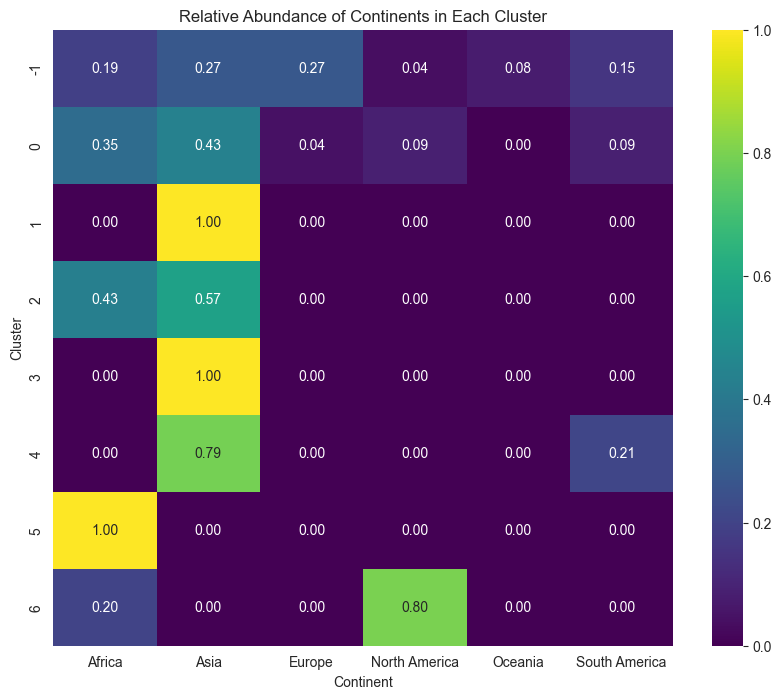

In [61]:
continent_cluster_proportion = pd.crosstab(df_merged['Cluster'], df_merged['Continent'], normalize='index')
plt.figure(figsize=(10, 8))
sns.heatmap(continent_cluster_proportion, annot=True, cmap='viridis', fmt=".2f")
plt.title('Relative Abundance of Continents in Each Cluster')
plt.xlabel('Continent')
plt.ylabel('Cluster')
plt.show()

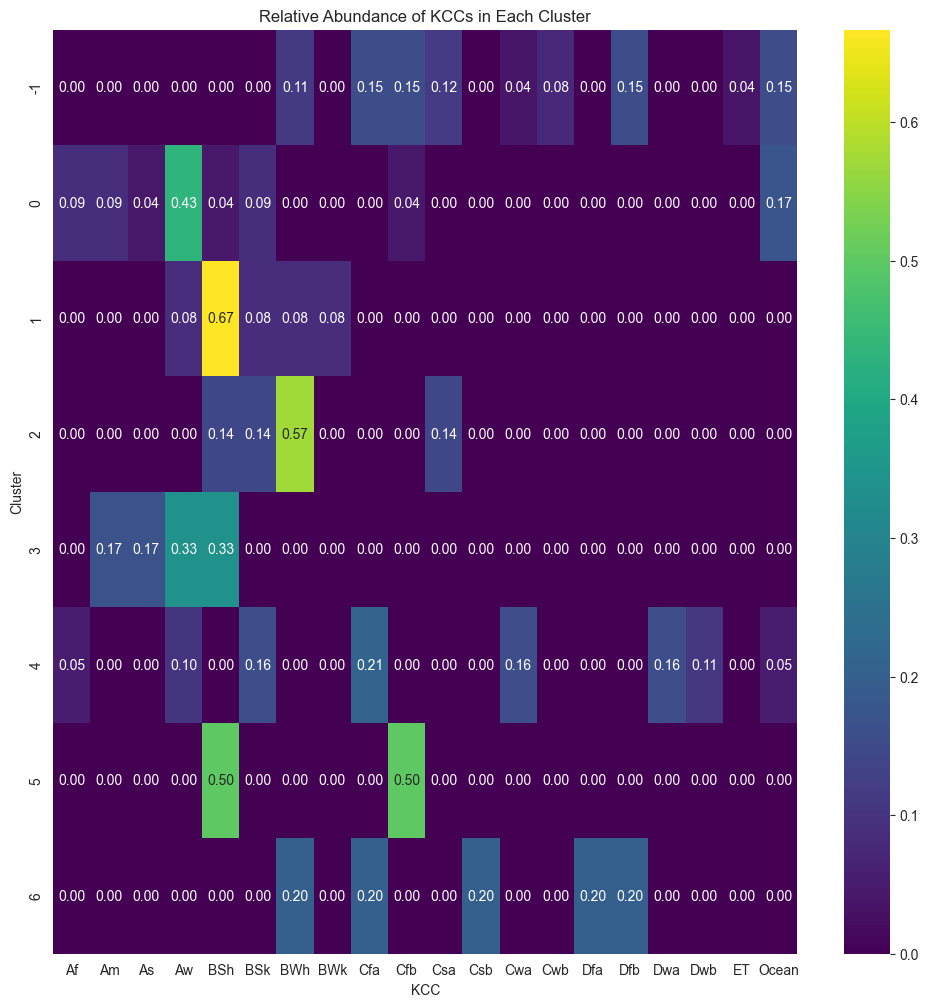

In [67]:
kcc_cluster_proportion = pd.crosstab(df_merged['Cluster'], df_merged['kcc'], normalize='index')
plt.figure(figsize=(12, 12))
sns.heatmap(kcc_cluster_proportion, annot=True, cmap='viridis', fmt=".2f")
plt.title('Relative Abundance of KCCs in Each Cluster')
plt.xlabel('KCC')
plt.ylabel('Cluster')
plt.show()

Visualization of geographic spread (Latitude, Longitude) for each cluster

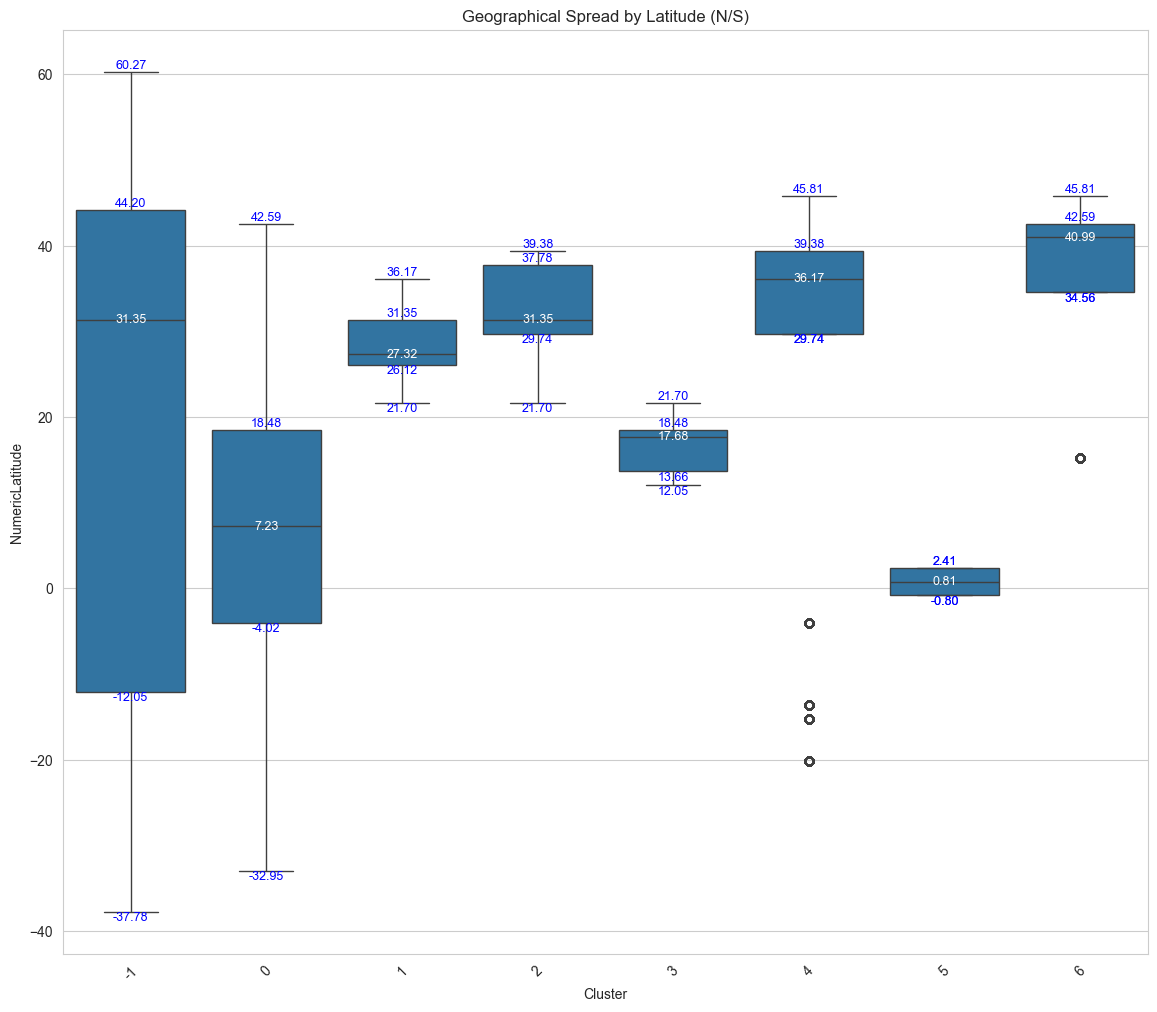

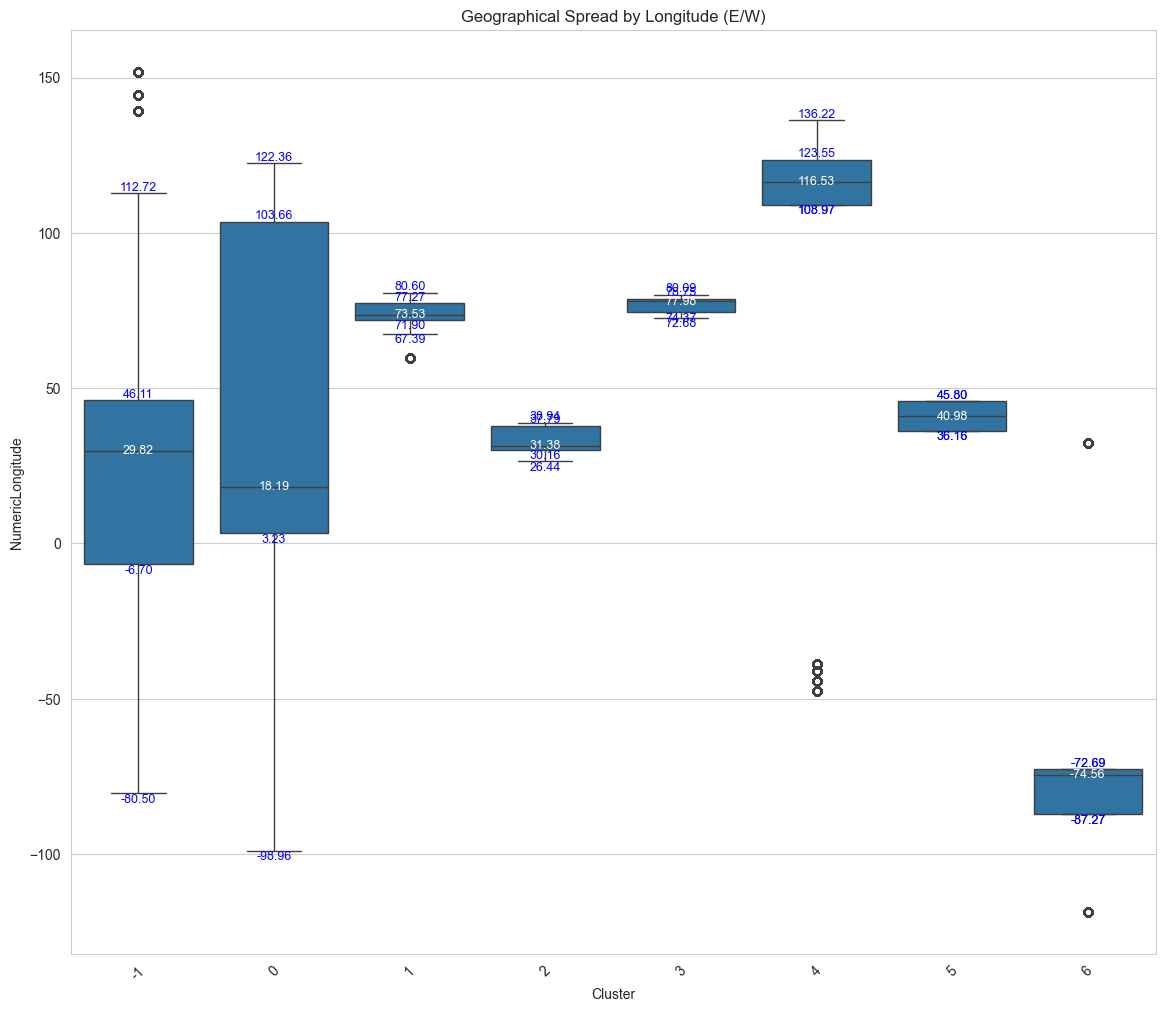

In [68]:
plt.figure(figsize=(14, 12))
sns.boxplot(x='Cluster', y='NumericLatitude', data=df_merged)

# Ensure you account for the noise cluster (-1) if present
unique_clusters = np.sort(df_merged['Cluster'].unique())
for cluster in unique_clusters:
    cluster_latitudes = df_merged[df_merged['Cluster'] == cluster]['NumericLatitude']
    percentiles = np.percentile(cluster_latitudes, [25, 50, 75])  # Q1, Median, Q3
    lower_whisker = np.min(cluster_latitudes[cluster_latitudes >= percentiles[0] - 1.5*(percentiles[2]-percentiles[0])])
    upper_whisker = np.max(cluster_latitudes[cluster_latitudes <= percentiles[2] + 1.5*(percentiles[2]-percentiles[0])])
    
    cluster_index = np.where(unique_clusters == cluster)[0][0]  # Find the index of the cluster for plotting
    plt.text(cluster_index, lower_whisker, f'{lower_whisker:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(cluster_index, percentiles[0], f'{percentiles[0]:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(cluster_index, percentiles[1], f'{percentiles[1]:.2f}', ha='center', va='center', fontsize=9, color='white')
    plt.text(cluster_index, percentiles[2], f'{percentiles[2]:.2f}', ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(cluster_index, upper_whisker, f'{upper_whisker:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

plt.title('Geographical Spread by Latitude (N/S)')
plt.ylabel('NumericLatitude')
plt.xlabel('Cluster')
plt.xticks(rotation=45)  # Ensure cluster labels are readable
plt.show()

plt.figure(figsize=(14, 12))
sns.boxplot(x='Cluster', y='NumericLongitude', data=df_merged)

for cluster in unique_clusters:
    cluster_longitudes = df_merged[df_merged['Cluster'] == cluster]['NumericLongitude']
    percentiles = np.percentile(cluster_longitudes, [25, 50, 75])
    lower_whisker = np.min(cluster_longitudes[cluster_longitudes >= percentiles[0] - 1.5*(percentiles[2]-percentiles[0])])
    upper_whisker = np.max(cluster_longitudes[cluster_longitudes <= percentiles[2] + 1.5*(percentiles[2]-percentiles[0])])
    
    cluster_index = np.where(unique_clusters == cluster)[0][0]
    plt.text(cluster_index, lower_whisker, f'{lower_whisker:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(cluster_index, percentiles[0], f'{percentiles[0]:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(cluster_index, percentiles[1], f'{percentiles[1]:.2f}', ha='center', va='center', fontsize=9, color='white')
    plt.text(cluster_index, percentiles[2], f'{percentiles[2]:.2f}', ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(cluster_index, upper_whisker, f'{upper_whisker:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

plt.title('Geographical Spread by Longitude (E/W)')
plt.ylabel('NumericLongitude')
plt.xlabel('Cluster')
plt.xticks(rotation=45)
plt.show()